In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm
import codecs
import array
import imageio as imageio
import cv2 as cv
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import dask
import time
from multiprocessing import Process# this is used for multithreading
import multiprocessing
import threading
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import plot_confusion_matrix

In [ ]:
os.chdir('/Volumes/KDH')
os.getcwd()

In [ ]:
#separating byte files and asm files
source = 'train'
destination_1 = 'byteFiles'
destination_2 = 'asmFiles'
# we will check if the folder 'byteFiles' exists if it not there we will create a folder with the same name
if not os.path.isdir(destination_1):
    os.makedirs(destination_1)
if not os.path.isdir(destination_2):
    os.makedirs(destination_2)
# so by the end of this snippet we will separate all the .byte files and .asm files
if os.path.isdir(source):
    data_files = os.listdir(source)
    for file in data_files:
        if file.startswith('._'):
            continue
        else: 
            if (file.endswith("bytes")):
                shutil.move(source+'/'+file,destination_1)
            if (file.endswith("asm")):
                shutil.move(source+'/'+file,destination_2)
                

In [ ]:
file_bytes=os.listdir('byteFiles')
file_bytes=[i for i in file_bytes if not i.startswith('._')]

In [ ]:
Y=pd.read_csv("/Users/kuladeep/AAI_assignment/MicrosoftMalware/trainLabels.csv")
filenames=Y['Id'].tolist()
class_y=Y['Class'].tolist()

## Extracting bi-gram features from byteFiles

In [ ]:
a=['00,01,02,03,04,05,06,07,08,09,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,28,29,2a,2b,2c,2d,2e,2f,30,31,32,33,34,35,36,37,38,39,3a,3b,3c,3d,3e,3f,40,41,42,43,44,45,46,47,48,49,4a,4b,4c,4d,4e,4f,50,51,52,53,54,55,56,57,58,59,5a,5b,5c,5d,5e,5f,60,61,62,63,64,65,66,67,68,69,6a,6b,6c,6d,6e,6f,70,71,72,73,74,75,76,77,78,79,7a,7b,7c,7d,7e,7f,80,81,82,83,84,85,86,87,88,89,8a,8b,8c,8d,8e,8f,90,91,92,93,94,95,96,97,98,99,9a,9b,9c,9d,9e,9f,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,aa,ab,ac,ad,ae,af,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,ba,bb,bc,bd,be,bf,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,ca,cb,cc,cd,ce,cf,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,da,db,dc,dd,de,df,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,ea,eb,ec,ed,ee,ef,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,fa,fb,fc,fd,fe,ff,??']
a=a[0].split(",")
b=[]
for i in a:
    for j in a:
        b.append(i+' '+j)

In [ ]:
string="ID,"
for i in b:
    string=string+i+','

In [ ]:
filenames=[]
#we remove the starting address 00401000
for file in file_bytes:
    if(file.endswith("bytes")):
        file=file.split('.')[0]
        text_file = open('byteFiles/'+file+".txt", 'w+')
        with open('byteFiles/'+file+".bytes","r") as fp:
            lines=""
            for line in fp:
                a=line.rstrip().split(" ")[1:]
                b=' '.join(a)
                b=b+"\n"
                text_file.write(b)
            fp.close()
            os.remove('byteFiles/'+file+".bytes")
        text_file.close()

In [ ]:
file_bytes=[i for i in file_bytes if i.endswith('.txt')]

In [ ]:
filenames2=[]
feature_matrix = np.zeros((len(file_bytes),66049),dtype=int)
k=0
byte_feature_file=open('/Users/kuladeep/AAI_assignment/MicrosoftMalware/bigram_bytes.csv','w+')
byte_feature_file.write(string)
byte_feature_file.write("\n")
for file in tqdm(file_bytes):
    filenames2.append(file)
    byte_feature_file.write(file+",")
    if(file.endswith("txt")):
        byte_file=open('byteFiles/'+file)
        for lines in byte_file:
            lines=lines.rstrip()
            line_hex_code=list(zip(lines.split(" ")[:-1],lines.split(" ")[1:]))
            for hex_code in line_hex_code:
                hex_code=list(hex_code)
                if hex_code[0]=='??':
                    hex_code[0]='100'
                if hex_code[1]=='??':
                    hex_code[1]='100'
                index=int(hex_code[0],16)*257+int(hex_code[1],16)
                feature_matrix[k][index]+=1
        byte_file.close()
       
    for i, row in enumerate(feature_matrix[k]):
        if i!=len(feature_matrix[k])-1:
            byte_feature_file.write(str(row)+",")
        else:
            byte_feature_file.write(str(row))   
    byte_feature_file.write("\n")
    k += 1 
byte_feature_file.close()

100%|██████████| 10868/10868 [6:15:51<00:00,  2.08s/it]    


## Converting ASM file to image

In [ ]:
# https://www.kaggle.com/code/paulrohan2020/microsoft-malware-detection-log-loss-of-0-0070
# create a folder image_asm to store image files from .asm files
if not os.path.isdir("image_file_asm"):
    os.mkdir("image_file_asm")
file_asm=os.listdir("asmFiles")
file_asm=[i for i in file_asm if not i.startswith('._')]

In [ ]:
for file in tqdm(file_asm):
    if(file.endswith("asm")):
        current_file = codecs.open("asmFiles/" +file, 'rb')
        size_of_current_asm_file = os.path.getsize("asmFiles/"+file)
    width_of_file = int(size_of_current_asm_file**0.5)
    remainder = size_of_current_asm_file % width_of_file 
    # To create array of single bytes, passing type code 'B'
    # "B" is for unsigned characters
    array_of_image = array.array('B')
    array_of_image.fromfile(current_file, size_of_current_asm_file-remainder)
    current_file.close()
    arr_of_generated_image = np.reshape(array_of_image[:width_of_file * width_of_file], (width_of_file, width_of_file))
    arr_of_generated_image = np.uint8(arr_of_generated_image)
    imageio.imwrite("image_file_asm"+'/' +file.split(".")[0] + '.png', arr_of_generated_image)


100%|██████████| 10868/10868 [2:15:17<00:00,  1.34it/s] 


## Extracting 800 features from ASM image files

In [ ]:
file_list_asm_files=os.listdir('image_file_asm')
file_list_asm_files=[i for i in file_list_asm_files if not i.startswith('._')]
with open("/Users/kuladeep/AAI_assignment/MicrosoftMalware/top_800_image_asm.csv", mode='w+') as top_800_image_asm: 
    top_800_image_asm.write(','.join(map(str, ["ID"]+["pixel_asm{}".format(i+1) for i in range(800)])))
    top_800_image_asm.write('\n')
    for image in tqdm(file_list_asm_files):
        file_id_asm_files=image.split(".")[0]
        asm_image_array=cv.imread("image_file_asm/"+image)
        asm_image_array=asm_image_array.flatten()[:800]
        top_800_image_asm.write(','.join(map(str, [file_id_asm_files]+list(asm_image_array))))
        top_800_image_asm.write('\n')

100%|██████████| 10868/10868 [14:01<00:00, 12.92it/s]


## Merging all features into single DataFrame

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
byte_features=pd.read_csv("/content/drive/MyDrive/result_with_size.csv")
byte_features=byte_features.drop('Unnamed: 0',axis=1)
byte_features.head(2)

,ID,0,1,2,3,4,5,6,7,8,...,f9,fa,fb,fc,fd,fe,ff,??,size,Class
0,01azqd4InC7m9JpocGv5,601905,3905,2816,3832,3345,3242,3650,3201,2965,...,3101,3211,3097,2758,3099,2759,5753,1824,4.234863,9
1,01IsoiSMh5gxyDYTl4CB,39755,8337,7249,7186,8663,6844,8420,7589,9291,...,439,281,302,7639,518,17001,54902,8588,5.538818,2


In [ ]:
byte_bigram_features=pd.read_csv("/content/drive/MyDrive/bigram_bytes.csv")
byte_bigram_features.info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10868 entries, 0 to 10867
Columns: 66051 entries, ID to Unnamed: 66050
dtypes: float64(1), int64(66049), object(1)
memory usage: 5.3 GB


In [ ]:
byte_bigram_features['ID']  = byte_bigram_features['ID'].str.split('.').str[0]
byte_bigram_features= byte_bigram_features.merge(byte_features[['ID','Class']], on='ID')

Normalize

In [ ]:
my_dict={}
my_dict1={}

In [ ]:
def normalize(df):
    for feature_name in tqdm(df.columns):
        if (str(feature_name) != str('ID') and str(feature_name)!=str('Class') and str(feature_name)!=str('Unnamed: 66050')):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            my_dict[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
        if (str(feature_name) == str('ID') or str(feature_name)==str('Class')):
            my_dict1[feature_name]=df[feature_name]
    return df
normalized_byte_features_with_bigrams= normalize(byte_bigram_features)


100%|██████████| 66052/66052 [00:33<00:00, 1997.99it/s]


In [ ]:
def normalize1(df):
    for feature_name in tqdm(df.columns):
        if (str(feature_name) != str('ID') and str(feature_name)!=str('Class') and str(feature_name)!=str('Unnamed: 66050')):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            df[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return df


In [ ]:
normalized_features1=pd.DataFrame(my_dict,dtype='float64')
normalized_features2=pd.DataFrame(my_dict1)
normalized_features1.replace(np.nan, 0, inplace=True)
normalized_features1.info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10868 entries, 0 to 10867
Columns: 66049 entries, 00 00 to ?? ??
dtypes: float64(66049)
memory usage: 5.3 GB


SELECT TOP 2000 FEATURES

In [ ]:
top_2000_features=SelectKBest(chi2, k=2000)
imp_features_byte_bigram = top_2000_features.fit_transform(normalized_features1, normalized_features2['Class'])

In [ ]:
top_2000_imp_byte_bigram_features=pd.DataFrame(imp_features_byte_bigram)

In [ ]:
top_2000_imp_byte_bigram_features.columns=[i for i in range(2000,4000,1)]

In [ ]:
top_2000_byte_bigram_features = pd.concat([normalized_features2["ID"], top_2000_imp_byte_bigram_features], axis=1)
top_2000_byte_bigram_features.shape

(10868, 2001)

Top_2000 features of bigram+256 unigram features

In [ ]:
top_2000_byte_bigram_features= top_2000_byte_bigram_features.merge(byte_features, on='ID')

ASM FILE FEATURES

In [ ]:
Y=pd.read_csv("/content/drive/MyDrive/trainLabels.csv")

In [ ]:
df_asm=pd.read_csv("/content/drive/MyDrive/asmoutputfile.csv")
Y.columns = ['ID', 'Class']
result_asm = pd.merge(df_asm, Y,on='ID', how='left')
result_asm.head()

,ID,HEADER:,.text:,.Pav:,.idata:,.data:,.bss:,.rdata:,.edata:,.rsrc:,...,edx,esi,eax,ebx,ecx,edi,ebp,esp,eip,Class
0,01kcPWA9K2BOxQeS5Rju,19,744,0,127,57,0,323,0,3,...,18,66,15,43,83,0,17,48,29,1
1,1E93CpP60RHFNiT5Qfvn,17,838,0,103,49,0,0,0,3,...,18,29,48,82,12,0,14,0,20,1
2,3ekVow2ajZHbTnBcsDfX,17,427,0,50,43,0,145,0,3,...,13,42,10,67,14,0,11,0,9,1
3,3X2nY7iQaPBIWDrAZqJe,17,227,0,43,19,0,0,0,3,...,6,8,14,7,2,0,8,0,6,1
4,46OZzdsSKDCFV8h7XWxf,17,402,0,59,170,0,0,0,3,...,12,9,18,29,5,0,11,0,11,1


In [ ]:
asm_size_byte_df=pd.read_csv("/content/drive/MyDrive/asm_with_size.csv")
asm_size_byte_df=asm_size_byte_df.drop('Unnamed: 0',axis=1)

In [ ]:
result_asm = pd.merge(result_asm, asm_size_byte_df.drop(['Class'], axis=1),on='ID', how='left')
result_asm.head()

,ID,HEADER:,.text:,.Pav:,.idata:,.data:,.bss:,.rdata:,.edata:,.rsrc:,...,esi,eax,ebx,ecx,edi,ebp,esp,eip,Class,size_asm
0,01kcPWA9K2BOxQeS5Rju,19,744,0,127,57,0,323,0,3,...,66,15,43,83,0,17,48,29,1,0.078190
1,1E93CpP60RHFNiT5Qfvn,17,838,0,103,49,0,0,0,3,...,29,48,82,12,0,14,0,20,1,0.063400
2,3ekVow2ajZHbTnBcsDfX,17,427,0,50,43,0,145,0,3,...,42,10,67,14,0,11,0,9,1,0.041695
3,3X2nY7iQaPBIWDrAZqJe,17,227,0,43,19,0,0,0,3,...,8,14,7,2,0,8,0,6,1,0.018757
4,46OZzdsSKDCFV8h7XWxf,17,402,0,59,170,0,0,0,3,...,9,18,29,5,0,11,0,11,1,0.037567


In [ ]:
top_800_features=pd.read_csv("/content/drive/MyDrive/top_800_image_asm.csv")

In [ ]:
result_asm = pd.merge(result_asm, top_800_features,on='ID', how='left')
result_asm.head()

,ID,HEADER:,.text:,.Pav:,.idata:,.data:,.bss:,.rdata:,.edata:,.rsrc:,...,pixel_asm791,pixel_asm792,pixel_asm793,pixel_asm794,pixel_asm795,pixel_asm796,pixel_asm797,pixel_asm798,pixel_asm799,pixel_asm800
0,01kcPWA9K2BOxQeS5Rju,19,744,0,127,57,0,323,0,3,...,114,114,105,105,105,103,103,103,104,104
1,1E93CpP60RHFNiT5Qfvn,17,838,0,103,49,0,0,0,3,...,114,114,105,105,105,103,103,103,104,104
2,3ekVow2ajZHbTnBcsDfX,17,427,0,50,43,0,145,0,3,...,114,114,105,105,105,103,103,103,104,104
3,3X2nY7iQaPBIWDrAZqJe,17,227,0,43,19,0,0,0,3,...,114,114,105,105,105,103,103,103,104,104
4,46OZzdsSKDCFV8h7XWxf,17,402,0,59,170,0,0,0,3,...,114,114,105,105,105,103,103,103,104,104


In [ ]:
# we normalize the data each column 
result_asm = normalize1(result_asm)
result_asm.head()

100%|██████████| 854/854 [00:09<00:00, 89.62it/s] 


,ID,HEADER:,.text:,.Pav:,.idata:,.data:,.bss:,.rdata:,.edata:,.rsrc:,...,pixel_asm791,pixel_asm792,pixel_asm793,pixel_asm794,pixel_asm795,pixel_asm796,pixel_asm797,pixel_asm798,pixel_asm799,pixel_asm800
0,01kcPWA9K2BOxQeS5Rju,0.107345,0.001092,0.0,0.000761,0.000023,0.0,0.000084,0.0,0.000072,...,1.0,1.0,0.897196,0.897196,0.897196,0.898734,0.898734,0.898734,0.9,0.9
1,1E93CpP60RHFNiT5Qfvn,0.096045,0.001230,0.0,0.000617,0.000019,0.0,0.000000,0.0,0.000072,...,1.0,1.0,0.897196,0.897196,0.897196,0.898734,0.898734,0.898734,0.9,0.9
2,3ekVow2ajZHbTnBcsDfX,0.096045,0.000627,0.0,0.000300,0.000017,0.0,0.000038,0.0,0.000072,...,1.0,1.0,0.897196,0.897196,0.897196,0.898734,0.898734,0.898734,0.9,0.9
3,3X2nY7iQaPBIWDrAZqJe,0.096045,0.000333,0.0,0.000258,0.000008,0.0,0.000000,0.0,0.000072,...,1.0,1.0,0.897196,0.897196,0.897196,0.898734,0.898734,0.898734,0.9,0.9
4,46OZzdsSKDCFV8h7XWxf,0.096045,0.000590,0.0,0.000353,0.000068,0.0,0.000000,0.0,0.000072,...,1.0,1.0,0.897196,0.897196,0.897196,0.898734,0.898734,0.898734,0.9,0.9


<h3> 4.5.1. Merging both asm and byte file features</h3>

In [ ]:
result_asm=result_asm.drop('Class',axis=1)

In [ ]:
print(top_2000_byte_bigram_features.shape)
print(result_asm.shape)

(10868, 2260)
(10868, 853)


In [ ]:
result_x = pd.merge(top_2000_byte_bigram_features,result_asm,on='ID', how='left')
result_y = result_x['Class']
result_x = result_x.drop(['ID','Class'], axis=1)
result_x.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,pixel_asm791,pixel_asm792,pixel_asm793,pixel_asm794,pixel_asm795,pixel_asm796,pixel_asm797,pixel_asm798,pixel_asm799,pixel_asm800
0,0.000000,0.000150,0.000000,0.000000,0.000000,0.000,0.000000,0.040230,0.066667,0.000000,...,0.219048,0.219048,0.214953,0.214953,0.214953,0.000000,0.000000,0.000000,0.0,0.0
1,0.003092,0.000226,0.014423,0.052023,0.033113,0.024,0.043478,0.028736,0.038095,0.019355,...,1.000000,1.000000,0.897196,0.897196,0.897196,0.898734,0.898734,0.898734,0.9,0.9
2,0.000736,0.000301,0.002404,0.011561,0.006623,0.016,0.000000,0.011494,0.009524,0.000000,...,1.000000,1.000000,0.897196,0.897196,0.897196,0.898734,0.898734,0.898734,0.9,0.9
3,0.000000,0.000075,0.406250,0.005780,0.026490,0.008,0.000000,0.000000,0.000000,0.006452,...,1.000000,1.000000,0.897196,0.897196,0.897196,0.898734,0.898734,0.898734,0.9,0.9
4,0.000147,0.000000,0.004808,0.000000,0.000000,0.000,0.017391,0.005747,0.000000,0.019355,...,1.000000,1.000000,0.897196,0.897196,0.897196,0.898734,0.898734,0.898734,0.9,0.9


In [ ]:
result_x=result_x.drop(['.BSS:','rtn','.CODE'],axis=1)

<h3> 4.5.3. Train and Test split</h3>

In [ ]:
X_train, X_test_merge, y_train, y_test_merge = train_test_split(result_x, result_y,stratify=result_y,test_size=0.20)
X_train_merge, X_cv_merge, y_train_merge, y_cv_merge = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

<h3> 4.5.5. XgBoost Classifier on final features</h3>

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_merge = le.fit_transform(y_train_merge)
y_cv_merge = le.fit_transform(y_cv_merge)
y_test_merge=le.fit_transform(y_test_merge)

log_loss for c =  10 is 0.03561249748668364
log_loss for c =  50 is 0.02165520540797234
log_loss for c =  100 is 0.021351327987700987
log_loss for c =  500 is 0.02096063250285928
log_loss for c =  1000 is 0.020960178514369925
log_loss for c =  2000 is 0.02096112422524921
log_loss for c =  3000 is 0.02096069917117237


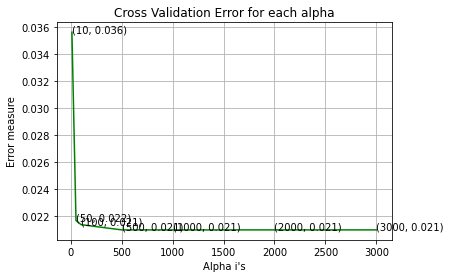

For values of best alpha =  1000 The train log loss is: 0.013198245214406499
For values of best alpha =  1000 The cross validation log loss is: 0.020960178514369925
For values of best alpha =  1000 The test log loss is: 0.035166287489879905


In [ ]:
alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i)
    x_cfl.fit(X_train_merge,y_train_merge)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train_merge, y_train_merge)
    predict_y = sig_clf.predict_proba(X_cv_merge)
    cv_log_error_array.append(log_loss(y_cv_merge, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(X_train_merge,y_train_merge,verbose=True)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_merge, y_train_merge)
predict_y = sig_clf.predict_proba(X_train_merge)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_merge, predict_y))
predict_y = sig_clf.predict_proba(X_cv_merge)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv_merge, predict_y))
predict_y = sig_clf.predict_proba(X_test_merge)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_merge, predict_y))

<h3> 4.5.5. XgBoost Classifier on final features with best hyper parameters using Random search</h3>

In [ ]:
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
     'tree_method': ['gpu_hist'],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl.fit(X_train_merge, y_train_merge)
print(random_cfl.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'tree_method': 'gpu_hist', 'subsample': 1, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.15, 'colsample_bytree': 0.5}


In [ ]:
x_cfl=XGBClassifier(n_estimators=500,max_depth=3,learning_rate=0.15,colsample_bytree=0.5,subsample=1,nthread=-1)
x_cfl.fit(X_train_merge,y_train_merge,verbose=True)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_merge, y_train_merge)
    
predict_y = sig_clf.predict_proba(X_train_merge)
print ('For values of best alpha = ', 500, "The train log loss is:",log_loss(y_train_merge, predict_y))
predict_y = sig_clf.predict_proba(X_cv_merge)
print('For values of best alpha = ', 500, "The cross validation log loss is:",log_loss(y_cv_merge, predict_y))
predict_y = sig_clf.predict_proba(X_test_merge)
print('For values of best alpha = ', 500, "The test log loss is:",log_loss(y_test_merge, predict_y))



For values of best alpha =  500 The train log loss is: 0.01174456067191477
For values of best alpha =  500 The cross validation log loss is: 0.020718524626783936
For values of best alpha =  500 The test log loss is: 0.028454908875815834


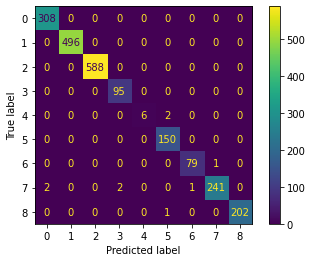

In [52]:
predictions = sig_clf.predict(X_test_merge)
cm = confusion_matrix(y_test_merge, predictions, labels=sig_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=sig_clf.classes_)
disp.plot()
plt.show()

MY APPROACH TO SOLVE THIS CASE STUDY

1)I extracted train.7z in my external harddisk of space 1TB,after extracting the file it occupied 200GB of space.<br>
2)I changed OS path to get access to the directory and extracted bigram features from byte files and 800 pixel intesitiy values from asm files.<br>
3)Bigram features Dataframe occupied 5.3 GB and to do normalization i used a dictionary to store column name as key and normalized values of that column as value.<br>
4)Performed hyperparameter tuning and obtained best parameters.<br>
5)model with best hyperparameter gave test log_loss of 0.02845.